<div style="background-color:black;color:white;font-size:25px;font-weight:bold;">
    <p style='line-height:39px;margin:14px;'>1.爬取【公众号：上海发布】治愈出院病例详情文章，记录单个病例确诊到出院的详情，
    存入文件</p>
    <p style='line-height:39px;margin:14px;'>2.整理数据，得到可分析样本</span><br/>
    <p style='line-height:39px;margin:14px;'>3.分析患者治愈周期及趋势</span>
</div>

In [1]:
import re
import requests
import urllib
from bs4 import BeautifulSoup as bs

from dateutil import parser as dateparse
from dateutil import rrule as rrule

from datetime import*
import time     #一定要写在datetime后面

import json
from selenium import webdriver

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### 爬取数据

"""
爬取可能会出现：{"err_msg":"freq control","ret":200013},需要间隔一天以后再爬（尚没有找到解决办法）
"""

In [2]:
earlist_cure_date = dateparse.parse('2020-01-27')

#### 爬取文章列表

In [6]:
headers_for_list = {
             "Accept":"*/*",
             "Accept-Encoding":"gzip, deflate, br",
             "Accept-Language":"zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2",
             "Connection":"keep-alive",
             "Cookie":"noticeLoginFlag=1; remember_acct=XinRuiGOAL_445; ua_id=kdwFycaP525HQR2pAAAAAH6MrnW80TdqywwUOKiaiSU=; pgv_pvi=1852565504; pgv_pvid=5970675800; pac_uid=0_5d8ddbbbd67a8; tvfe_boss_uuid=2f521cf4e0173472; xid=e6d4b59648bc3efe1494f3bbde6a83b5; mm_lang=zh_CN; wxuin=76737050911159; XWINDEXGREY=0; mobileUV=1_16fed07c7d1_b664e; pgv_info=ssid=s3833722896; pgv_si=s3150308352; uuid=46cbb1ed31eca1419d3dfae289ed6b2a; ticket=e8143adf9a8ef7620dda4617dd401b7ea56619fe; ticket_id=gh_b759a638f7db; cert=uYuAwmqDNzfbF2fQW0oh67Ns08twZARG; rewardsn=; wxtokenkey=777; noticeLoginFlag=1; remember_acct=XinRuiGOAL_445; openid2ticket_oedJlt1wKXdcZTPtAgjdmhg3n1SM=fwpqGwk6K1VssHOrulO5fZfUZ0DBTE91vvPiptTMbyc=; bizuin=3070900654; rand_info=CAESIIIFu84ysAVudPkdUOaIWZVJtyDjWHQio8kK+w68yyou; slave_bizuin=3070900654; data_bizuin=3076903545; data_ticket=8gSvGAyY5YA+5N4aqTfhY52dAyhayksNuhkryVk0hnNa9AUyGyYbcYiuZLFmvA0U; slave_sid=aDJEV1FmTzViU05Ld0VXR3A0SjdXMVFKc25rREVpQ05kMVJoMEFDZW9pRUNjQkMzUmlYSHJHMW5rU2wxTXdRSXE0SmVLT3RlMGUyelFuSUs1ek9DTjhCM1JpSjMzY2RMeVZmVkthMkRMNjFFYk91azdES0c1S0R4dGNTRW9oU0NuMlhpTWFVejZLOUd1Z21N; slave_user=gh_b759a638f7db",
             "Host":"mp.weixin.qq.com",
             "Referer":"https://mp.weixin.qq.com/cgi-bin/appmsg?t=media/appmsg_edit&action=edit&type=10&isMul=1&isNew=1&share=1&lang=zh_CN&token=1322400924&token=1322400924&lang=zh_CN",
             "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:69.0) Gecko/20100101 Firefox/69.0",
             "X-Requested-With":"XMLHttpRequest"
            }

In [7]:
request_data_for_list = {
                    'action':'list_ex',
                    'begin':0,
                    'count':5,
                    'fakeid':'MjM5NTA5NzYyMA==',     #公众号fakeId
                    'type':9,
                    'query':'痊愈出院',
                    'token':'823584831',     #这个会过期(cookie也要换)
                    'lang':'zh_CN',
                    'f':'json',
                    'ajax':1
                }

In [8]:
articleLink_list = []     #存放所有有用的文章链接
real_cure_date_list = []     #保存治愈时间，与文章链接同index
all_article_link_get = False

url_for_articleList = 'https://mp.weixin.qq.com/cgi-bin/appmsg'
while (all_article_link_get == False):
    response_articleList = requests.get(url_for_articleList,params=request_data_for_list,headers=headers_for_list)
    #print(f"第{int(request_data_for_list['begin']/5)+1}页")
    #print(f"返回状态：{response_articleList.status_code}")
    #response_articleList.encoding     #utf-8
    articleList_page_text = response_articleList.text
    articleList_page_model = bs(articleList_page_text,'lxml')
    articleList_json = json.loads(articleList_page_model.find("p").text)     #返回的不是html，而是json串，如此处理甚是奇葩
    article_list_info = articleList_json['app_msg_list']
    print(f"size of articles:{len(article_list_info)}")
    for article_info in article_list_info:
        article_time = datetime.fromtimestamp(article_info['create_time'])
        if article_time < earlist_cure_date:
            all_article_link_get = True
            break
        article_link = article_info['link']
        real_cure_date = article_time.strftime('%Y-%m-%d')
        articleLink_list.append(article_link)
        real_cure_date_list.append(real_cure_date)
        print(article_link)
    request_data_for_list['begin'] = request_data_for_list['begin'] + 5
print(f"总链接数：{len(articleLink_list)}")
    #page_model
    #li = page_model.find_all(class_='weui-desktop-vm_default')
    #li

size of articles:5
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654127608&idx=2&sn=92b5dd6082584d2892f0512854b2b5fa&chksm=bd3bd8838a4c5195c1154cb636f1e5ac1fb78d77eefd2906a8bcef358eb6540a5f7380f1b27b#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654127413&idx=1&sn=1cf324915536aba1cb50d3f1c4a8c8e4&chksm=bd3bd84e8a4c5158014289008858e25dcf1a7e266e4e73b29bea16ac2842e7d2a5e654a495a9#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654127254&idx=1&sn=8cfcea58474ad7c7176e5875e24b2d23&chksm=bd3bd9ed8a4c50fb2a84e93e9006444e3b9dfda7b5a62308e5b90e7b46110c758565ce595d31#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654127090&idx=2&sn=5cb093268eef7cfc558b66d896ad1c49&chksm=bd3bde898a4c579f426b9574e2e8454e04f22b7bfec6efcca66ca8924875cda5b8248bf67d01#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654126978&idx=1&sn=4f53983042c79e81aac248eb59b14bb6&chksm=bd3bdef98a4c57ef9975475adb009f8775a35b5a38c6af6fd1f675b40a86ba590cf4a32c86e7#rd
size of articles:5
ht

#### 爬取文章详情并解析，合成所需数据

In [9]:
header_for_detail = {
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
                        'Accept-Encoding': 'gzip, deflate, br',
                        'Accept-Language': 'zh-CN,zh;q=0.9',
                        'Cache-Control': 'max-age=0',
                        'Connection': 'keep-alive',
                        'Cookie': 'LW_uid=y1F5a7H4V2M3g5p4s10850p2Z6; eas_sid=91x5173472D3B5T4F1S8J0z4J0; pgv_pvi=7368888320; pgv_pvid=2317645400; pac_uid=0_5dd4fcb0c4bed; tvfe_boss_uuid=70f723d6e0be5c83; LW_sid=L185r744R9a9Q6Z355f5d7J8q0; wxuin=76739633599257; sd_userid=84941581685703780; sd_cookie_crttime=1581685703780; pgv_info=ssid=s7546132330; rewardsn=; wxtokenkey=777',
                        'Host': 'mp.weixin.qq.com',
                        'If-Modified-Since': 'Mon, 2 Mar 2020 13:22:34 +0800',
                        'Referer': 'http://localhost:8888/notebooks/cure_time_exploration.ipynb',
                        'Sec-Fetch-Mode': 'navigate',
                        'Sec-Fetch-Site': 'cross-site',
                        'Sec-Fetch-User': '?1',
                        'Upgrade-Insecure-Requests': '1',
                        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'
}

In [10]:
request_data_for_detail = {
                                '__biz': 'MjM5NTA5NzYyMA==',
                                'mid': 2654125379,
                                'idx': 1,
                                'sn': 'a134c1aaa746c99ce6c73933b26e7a92',
                                'chksm': 'bd3ba0388a4c292ed15f39aabdf7b7f352964c863d61a0cd36b512917aa669de3effc0090fce',
                            }

In [11]:
count_index = 0     #患者编号，从0开始
#cure_patient_info = []     #记录每一位患者相关信息
cure_detail_list = [['p_num','age','gender','confirm_date','cure_date']]     #初始化出院患者信息列表(患者编号,年龄,性别,确诊时间,出院时间)

for i,article_url in enumerate(articleLink_list):
    cur_real_cure_date = real_cure_date_list[i]
    print(f"治愈日期：{cur_real_cure_date}")
    
    browser = webdriver.Chrome('./chromedriver.exe')
    browser.get(article_url)
    time.sleep(5)
    detail_text = browser.page_source
    #print(f"返回状态：{response_articleDetail.status_code},返回编码集：{response_articleDetail.encoding}")
    #detail_text = response_articleDetail.text
    detail_page_model = bs(detail_text,'lxml')
    mother_node = detail_page_model.find('span',text=re.compile('卫*健*委今*')).parent.parent #不知道为什么这样可以,前面加个"市"就匹配不上
    if mother_node.name != 'section':     #又蒙对了一把？
        mother_node = mother_node.parent
    patients_content = mother_node.find_all('p')

    for patient_piece in patients_content:
        patient_tag = patient_piece.find('span')
        if patient_tag == None:
            patient_tag = patient_piece.text     #有的段落不带span
        if type(patient_tag) != str:     #在重新赋值以后，类型也改变了,这里str不能加引号
            patient_tag = patient_tag.text
        #print(f"出院病例详情：{patient_tag}")
        gender = ""
        age = 0
        if (str(patient_tag).find("确诊为") == -1 and str(patient_tag).find("确认为") == -1) or str(patient_tag).find("死亡") != -1:
            continue
        else:
            info_list = patient_tag.split("，")     #中文逗号
            for info in info_list:
                if info == "男" or info == "女":
                    gender = info
                elif info.find("岁") != -1:
                    age = info[0:info.find('岁')]
                elif (info.find('确诊为') != -1) or (info.find('确认为') != -1):
                    regex_month = re.compile('\d+月')
                    regex_date = re.compile('\d+日')
                    reo_month = regex_month.search(info)
                    if reo_month != None:
                        month_in_text = info[reo_month.start():reo_month.end()-1]
                        if int(month_in_text) < 10:
                            month_in_text = '0' + month_in_text
                    reo_date = regex_date.search(info)
                    if reo_date != None:
                        date_in_text = info[reo_date.start():reo_date.end()-1]
                        if int(date_in_text) < 10:
                            date_in_text = '0' + date_in_text
                    confirm_date_str = '2020-'+month_in_text+"-"+date_in_text
                    confirm_date = dateparse.parse(confirm_date_str) 
                else:
                    continue
            cure_detail_info = [count_index,age,gender,confirm_date,dateparse.parse(cur_real_cure_date)]
            print(f"出院病例集合：{cure_detail_info}")
            cure_detail_list.append(cure_detail_info)
            count_index += 1
    browser.close()
print(f'治愈总人数：{len(cure_detail_list)-1}')

治愈日期：2020-03-11
出院病例集合：[0, '70', '男', datetime.datetime(2020, 2, 13, 0, 0), datetime.datetime(2020, 3, 11, 0, 0)]
治愈日期：2020-03-10
出院病例集合：[1, '20', '女', datetime.datetime(2020, 2, 14, 0, 0), datetime.datetime(2020, 3, 10, 0, 0)]
出院病例集合：[2, '52', '女', datetime.datetime(2020, 2, 14, 0, 0), datetime.datetime(2020, 3, 10, 0, 0)]
出院病例集合：[3, '37', '男', datetime.datetime(2020, 2, 10, 0, 0), datetime.datetime(2020, 3, 10, 0, 0)]
出院病例集合：[4, '42', '男', datetime.datetime(2020, 2, 14, 0, 0), datetime.datetime(2020, 3, 10, 0, 0)]
治愈日期：2020-03-09
出院病例集合：[5, '2', '男', datetime.datetime(2020, 2, 25, 0, 0), datetime.datetime(2020, 3, 9, 0, 0)]
治愈日期：2020-03-08
出院病例集合：[6, '31', '女', datetime.datetime(2020, 2, 2, 0, 0), datetime.datetime(2020, 3, 8, 0, 0)]
治愈日期：2020-03-07
出院病例集合：[7, '32', '男', datetime.datetime(2020, 2, 8, 0, 0), datetime.datetime(2020, 3, 7, 0, 0)]
出院病例集合：[8, '42', '男', datetime.datetime(2020, 2, 7, 0, 0), datetime.datetime(2020, 3, 7, 0, 0)]
出院病例集合：[9, '38', '男', datetime.datetime(2020, 

治愈日期：2020-02-22
出院病例集合：[93, '67', '女', datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[94, '63', '男', datetime.datetime(2020, 2, 13, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[95, '51', '女', datetime.datetime(2020, 1, 24, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[96, '76', '女', datetime.datetime(2020, 1, 25, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[97, '62', '女', datetime.datetime(2020, 1, 26, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[98, '37', '男', datetime.datetime(2020, 1, 30, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[99, '56', '男', datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[100, '27', '女', datetime.datetime(2020, 2, 4, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[101, '33', '男', datetime.datetime(2020, 2, 13, 0, 0), datetime.datetime(2020, 2, 22, 0, 0)]
出院病例集合：[102, '33', '女', datetime.datetime(2020, 2, 12, 0, 0), datetime.datetime(2020, 2, 22, 

治愈日期：2020-02-16
出院病例集合：[181, '57', '女', datetime.datetime(2020, 2, 8, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[182, '41', '女', datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[183, '69', '男', datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[184, '66', '女', datetime.datetime(2020, 1, 31, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[185, '66', '男', datetime.datetime(2020, 2, 7, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[186, '32', '女', datetime.datetime(2020, 1, 31, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[187, '62', '女', datetime.datetime(2020, 1, 26, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[188, '68', '女', datetime.datetime(2020, 1, 31, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[189, '40', '男', datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
出院病例集合：[190, '70', '男', datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 2,

治愈日期：2020-02-12
出院病例集合：[264, '24', '女', datetime.datetime(2020, 1, 30, 0, 0), datetime.datetime(2020, 2, 12, 0, 0)]
出院病例集合：[265, '31', '男', datetime.datetime(2020, 1, 30, 0, 0), datetime.datetime(2020, 2, 12, 0, 0)]
出院病例集合：[266, '31', '女', datetime.datetime(2020, 2, 4, 0, 0), datetime.datetime(2020, 2, 12, 0, 0)]
出院病例集合：[267, '35', '女', datetime.datetime(2020, 2, 4, 0, 0), datetime.datetime(2020, 2, 12, 0, 0)]
治愈日期：2020-02-11
出院病例集合：[268, '9', '男', datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 2, 11, 0, 0)]
治愈日期：2020-02-11
出院病例集合：[269, '63', '男', datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 2, 11, 0, 0)]
出院病例集合：[270, '40', '女', datetime.datetime(2020, 1, 28, 0, 0), datetime.datetime(2020, 2, 11, 0, 0)]
出院病例集合：[271, '55', '男', datetime.datetime(2020, 2, 2, 0, 0), datetime.datetime(2020, 2, 11, 0, 0)]
出院病例集合：[272, '66', '男', datetime.datetime(2020, 2, 3, 0, 0), datetime.datetime(2020, 2, 11, 0, 0)]
治愈日期：2020-02-10
出院病例集合：[273, '42', '女', datetime.datetime(

### 数据清洗

In [12]:
df_cure_info = pd.DataFrame(data=cure_detail_list[1:],columns=cure_detail_list[0])
df_cure_info.to_excel('cure_patients_in_shanghai.xlsx')
df_cure_info.tail()

,p_num,age,gender,confirm_date,cure_date
310,310,44,男,2020-01-23,2020-01-31
311,311,32,男,2020-01-21,2020-01-29
312,312,21,女,2020-01-22,2020-01-28
313,313,56,男,2020-01-18,2020-01-27
314,314,58,女,2020-01-18,2020-01-27


In [13]:
df_cure_info.columns

Index(['p_num', 'age', 'gender', 'confirm_date', 'cure_date'], dtype='object')

In [14]:
df_cure_info.shape

(315, 5)

In [15]:
df_cure_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 5 columns):
p_num           315 non-null int64
age             315 non-null object
gender          315 non-null object
confirm_date    315 non-null datetime64[ns]
cure_date       315 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 12.4+ KB


In [16]:
df_cure_info.dtypes

p_num                    int64
age                     object
gender                  object
confirm_date    datetime64[ns]
cure_date       datetime64[ns]
dtype: object

In [17]:
df_cure_info.drop_duplicates
df_cure_info.shape

(315, 5)

In [18]:
df_cure_info.age = df_cure_info.age.astype(int)
df_cure_info.dtypes

p_num                    int64
age                      int32
gender                  object
confirm_date    datetime64[ns]
cure_date       datetime64[ns]
dtype: object

In [19]:
df_cure_info[df_cure_info['age']==0]     #经查验，此二人确诊时年龄均不满1岁

,p_num,age,gender,confirm_date,cure_date
133,133,0,女,2020-02-03,2020-02-20
198,198,0,女,2020-02-05,2020-02-15


In [20]:
(df_cure_info.cure_date-df_cure_info.confirm_date).dt.days     #此方法似乎时好时坏

0      27
1      25
2      25
3      29
4      25
       ..
310     8
311     8
312     6
313     9
314     9
Length: 315, dtype: int64

In [21]:
df_cure_info['cure_during'] = df_cure_info.apply(lambda x:x.cure_date - x.confirm_date,axis=1).astype('timedelta64[D]').astype(int)
df_cure_info

,p_num,age,gender,confirm_date,cure_date,cure_during
0,0,70,男,2020-02-13,2020-03-11,27
1,1,20,女,2020-02-14,2020-03-10,25
2,2,52,女,2020-02-14,2020-03-10,25
3,3,37,男,2020-02-10,2020-03-10,29
4,4,42,男,2020-02-14,2020-03-10,25
...,...,...,...,...,...,...
310,310,44,男,2020-01-23,2020-01-31,8
311,311,32,男,2020-01-21,2020-01-29,8
312,312,21,女,2020-01-22,2020-01-28,6
313,313,56,男,2020-01-18,2020-01-27,9


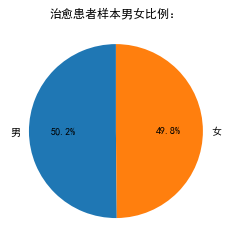

In [22]:
#样本男女比例
df_cure_info.gender.value_counts()
plt.pie(df_cure_info.gender.value_counts(),autopct='%1.1f%%',shadow=False,startangle=90,labels=['男','女'])     #autopct控制输出比例
plt.title('治愈患者样本男女比例：')
plt.rcParams['font.sans-serif']=['SimHei']     #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     #用来正常显示负号
plt.show()

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """


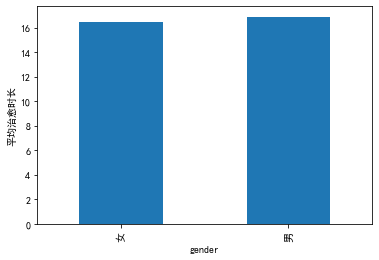

In [23]:
#治愈时长与性别无关
cure_groupby_gender = df_cure_info.groupby('gender').cure_during.mean()
plt.xlabel('年龄段')
plt.ylabel('平均治愈时长')
cure_groupby_gender.plot('bar')

In [24]:
#治愈时长数据统计
df_cure_info.cure_during.describe()

count    315.000000
mean      16.685714
std        7.135603
min        6.000000
25%       12.000000
50%       15.000000
75%       21.000000
max       38.000000
Name: cure_during, dtype: float64

13    26
12    23
16    22
10    21
15    21
Name: cure_during, dtype: int64
治愈耗时对应人数排前五的分别为：['13天', '12天', '16天', '10天', '15天']，      占总人数的：35.9%


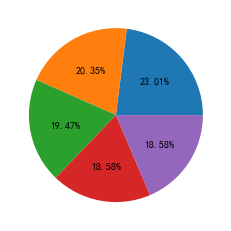

In [75]:
s_major_cure_during = df_cure_info.cure_during.value_counts().head(5)
print(s_major_cure_during)
plt.pie(s_major_cure_during,autopct="%1.2f%%",startangle=0)
print(f'治愈耗时对应人数排前五的分别为：{[(str(days) + "天") for days in list(s_major_cure_during.index)]}，\
      占总人数的：{round(s_major_cure_during.sum()/df_cure_info.cure_during.value_counts().sum(),3)*100}%')

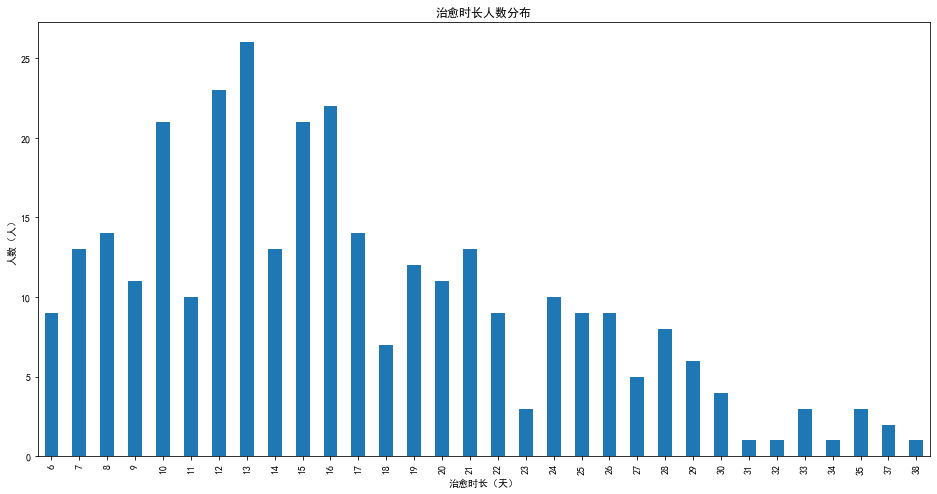

In [76]:
#治愈时长与对应人数的分布
se_cuduring = df_cure_info.cure_during.value_counts().sort_index()
se_cuduring
plt.figure(figsize=(16,8))
plt.title('治愈时长人数分布')
plt.xlabel('治愈时长（天）')
plt.ylabel('人数（人）')
se_cuduring.plot(kind='bar',stacked=True)

In [77]:
# 区分年龄段
def seperate_age(age):
    if age >= 0 and age < 12:     #儿童
        age_level = 0
    elif age >= 12 and age < 18:     #少年
        age_level = 1
    elif age >= 18 and age < 25:     #青春
        age_level = 2
    elif age >= 25 and age < 35:     #后青春
        age_level = 3
    elif age >= 35 and age < 60:     #第二人生
        age_level = 4
    elif age >= 60 and age < 80:     #暮年
        age_level = 5
    else:     #长寿老年
        age_level = 6
    
    return age_level

In [78]:
df_cure_info['age_level'] = df_cure_info['age'].apply(seperate_age)
df_cure_info.head()

,p_num,age,gender,confirm_date,cure_date,cure_during,age_level
0,0,70,男,2020-02-13,2020-03-11,27,5
1,1,20,女,2020-02-14,2020-03-10,25,2
2,2,52,女,2020-02-14,2020-03-10,25,4
3,3,37,男,2020-02-10,2020-03-10,29,4
4,4,42,男,2020-02-14,2020-03-10,25,4


(array([  9.,   3.,  12.,  50., 141.,  96.,   4.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

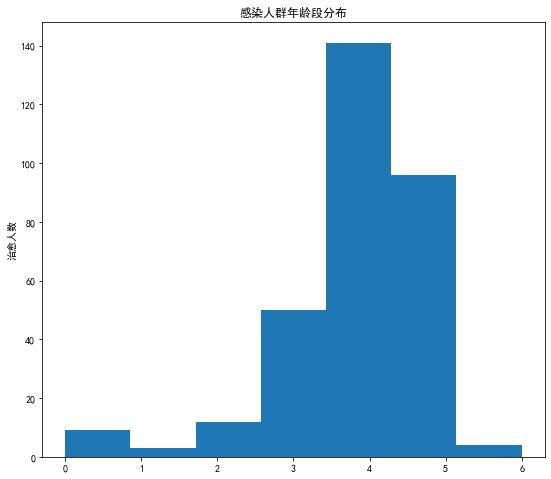

In [134]:
#年龄段分布
plt.figure(figsize=(9,8))
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.title('感染人群年龄段分布')
plt.ylabel('治愈人数')
plt.hist(x=df_cure_info.age_level,bins=7)

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  import sys


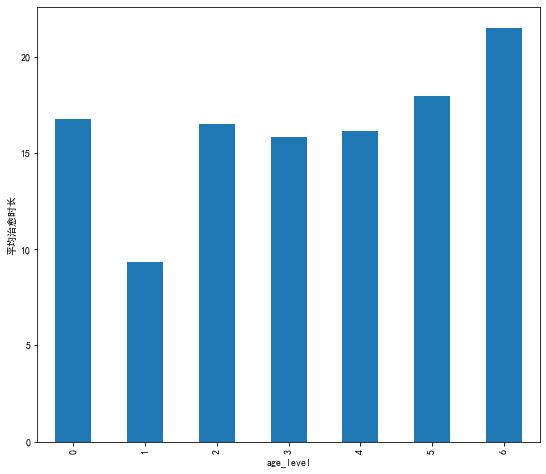

In [137]:
#年龄段与治愈时长的关系（无明显关联）
plt.figure(figsize=(9,8))
cure_groupby_ageLevel = df_cure_info.groupby('age_level').cure_during.mean()
# plt.xlabel('年龄段')
plt.ylabel('平均治愈时长')
plt.xticks([0,1,2,3,4,5,6,7,8],['0岁','12岁','18岁','25岁','35岁','60岁','80岁','80岁以上'])
cure_groupby_ageLevel.plot('bar')

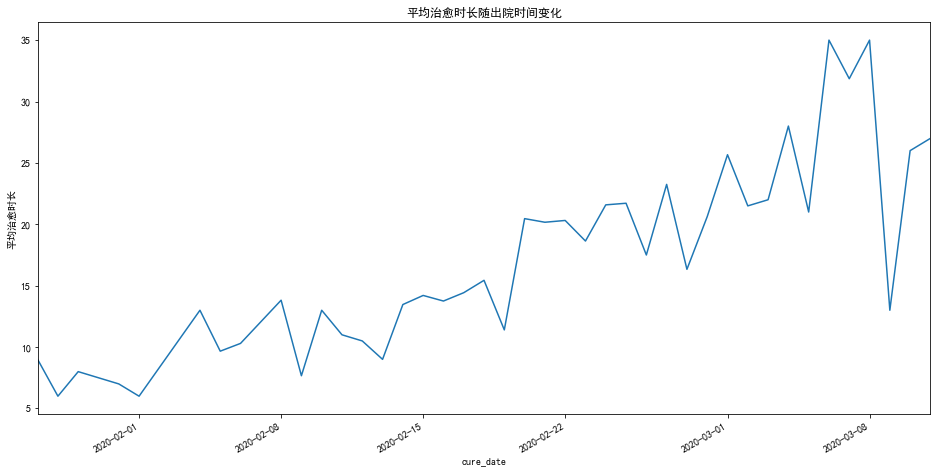

In [139]:
#随着出院日期后延，平均治愈时长相对加长？
se_cureDuring_with_cureDate = df_cure_info.groupby(['cure_date']).cure_during.mean()
plt.figure(figsize=(16,8))
plt.title('平均治愈时长随出院时间变化')
# plt.xlabel("治愈日期")
plt.ylabel('平均治愈时长')
se_cureDuring_with_cureDate.plot()

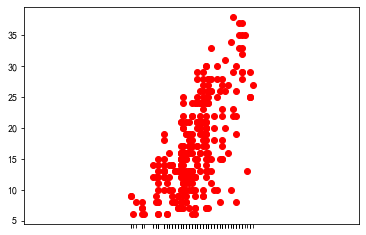

In [140]:
#治愈时长与确诊日期的关系（确诊日期越靠后，治愈时长越短？）
#df_each_cure_during = df_cure_info['cure_date','cure_during']
x = df_cure_info.cure_date
y = df_cure_info.cure_during
plt.scatter(x,y,color='red')
plt.xticks(x,())
plt.show()

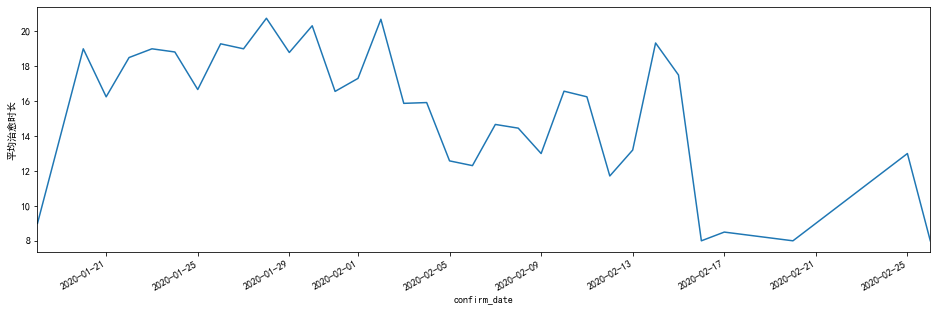

In [142]:
#随着确诊日期后延，平均治愈时长相对缩短？
se_cureDuring_with_confirmDate = df_cure_info.groupby(['confirm_date']).cure_during.mean()
plt.figure(figsize=(16,5))
# plt.xlabel("确诊日期")
plt.ylabel('平均治愈时长')
se_cureDuring_with_confirmDate.plot()

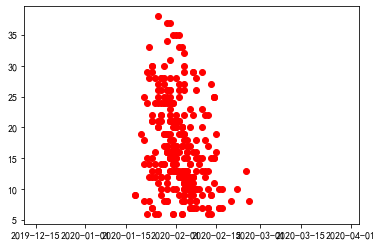

In [143]:
plt.scatter(df_cure_info.confirm_date,df_cure_info.cure_during,color='red')

## Draft

In [10]:
#单页数据采集调试
index_list = []
for i,cure_date in enumerate(real_cure_date_list):
    if str(cure_date) in ['2020-01-27','2020-01-28','2020-01-29','2020-01-31','2020-02-07','2020-02-26','2020-03-02']:
        index_list.append(i)
    else:
        continue
print(index_list)
for arti_index in index_list:
    print(articleLink_list[arti_index])

[1, 6, 26, 31, 32, 33, 34]
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654126329&idx=2&sn=068aee7a5aab4cf7c9f7f19933195665&chksm=bd3bdd828a4c5494cb7cb9dff4bb84aa5f6d9374e996d2e10386259dbe3d330eb9b2a3ba5661#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654125511&idx=1&sn=54b3b4334903032154543ea6e22a7b71&chksm=bd3ba0bc8a4c29aaac9d358b259d38bb125309789956c626b1cb72b8e7bb6bcc2f86f9937856#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654122959&idx=2&sn=0b6b699922d86c0e59f878cc8ce4efec&chksm=bd3baeb48a4c27a2c76bafbe1a599827984ddd59267fec9a90a70617776716ce298f23d5a484#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654122097&idx=1&sn=1e08183d9f4c0e420157de52e8f0ee11&chksm=bd3bad0a8a4c241c57eddbea51bc7ae9b49d7d9e0d7fd1f345955833465cf074dbb052a38411#rd
http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654121840&idx=1&sn=a2630dd799478fa50ba03c10b15b577d&chksm=bd3bb20b8a4c3b1dcfb25863490b21417e44222c076f3fefa2d319fb8d968c94fbb680e5c7d6#rd
http://mp.wei

In [44]:
browser = webdriver.Chrome('./chromedriver.exe')
browser.get("http://mp.weixin.qq.com/s?__biz=MjM5NTA5NzYyMA==&mid=2654121840&idx=1&sn=a2630dd799478fa50ba03c10b15b577d&chksm=bd3bb20b8a4c3b1dcfb25863490b21417e44222c076f3fefa2d319fb8d968c94fbb680e5c7d6#rd")
text_29 = browser.page_source
page_model_29 = bs(text_29,'lxml')
node_29 = page_model_29.find('span',text=re.compile('卫*健*委今*')).parent.parent
content_29 = node_29.find_all('p')
#print(f"所有的P:{content_29}")
for piece_29 in content_29:
    #print(f'有无span？：{piece_29.find("span")}')
    tag_29 = piece_29.find('span')
    if tag_29 == None:
        tag_29 = piece_29.text
    print(f"tag类型：{type(tag_29)}")
    gender = ""
    age = 0
    if (type(tag_29) == None) or \
    (str(tag_29).find("确诊为") == -1 and str(tag_29).find("确认为") == -1) or\
    str(tag_29).find("死亡") != -1:
        print("It's useless!" )
        continue
    else:
        print('begin collection')

tag类型：<class 'bs4.element.Tag'>
It's useless!
tag类型：<class 'bs4.element.Tag'>
It's useless!
tag类型：<class 'str'>
begin collection
tag类型：<class 'bs4.element.Tag'>
It's useless!


In [42]:
type(content_29)

bs4.element.ResultSet

In [68]:
earlist_cure_date = dateparse.parse('2020-01-27')
earlist_cure_date

datetime.datetime(2020, 1, 27, 0, 0)

In [69]:
publish_time = (datetime.fromtimestamp(1582252390))
print(f"valid:{publish_time > earlist_cure_date}")

valid:True


In [75]:
t1 = publish_time.strftime('%Y-%m-%d')
type(t1)

str

In [14]:
print(type(articleList_json))

<class 'dict'>


TypeError: 'list' object is not callable

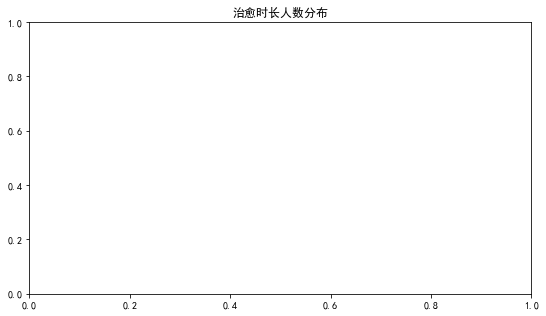

In [66]:
se_cuduring = df_cure_info.cure_during.value_counts().sort_index()
se_cuduring
plt.figure(figsize=(9,5))
plt.title('治愈时长人数分布')
plt.xlabel('治愈时长（天）')
plt.ylabel('人数（人）')
se_cuduring.plot(kind='bar',stacked=True)

In [53]:
[str(days) + '天' for days in list(s_major_cure_during.index)]

['13天', '12天', '16天', '10天', '15天']

In [93]:
from matplotlib import pyplot as plt
type(plt.xticks)

function

In [91]:
del plt.xlabel
type(plt)

module